In [17]:
import os
import sys
from IPython.display import display, Javascript

def restart_kernel():
    """Restart the Jupyter Notebook kernel to reflect changes in modules and packages."""
    display(Javascript("Jupyter.notebook.kernel.restart()"))
    print("Kernel is restarting...")

In [18]:
restart_kernel()

import bptf
from bptf import BPTF
import numpy as np
import pandas as pd
import sparse
import os
import shutil
from tqdm import tqdm
import pickle
import scipy.stats as st
import matplotlib.pyplot as plt
import torch
import tensorly
import cupy

import multiprocessing
from joblib import Parallel, delayed
from tqdm.contrib.concurrent import process_map

import gc
gc.collect()

<IPython.core.display.Javascript object>

Kernel is restarting...


843

In [19]:
def dataframe_to_sparse_tensor(data, country_indices, date_indices, database_indices, cameo_col='CAMEO_Code', events_col='Num_Events'):
    """
    Converts a pandas DataFrame into an sptensor.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        country_indices (pd.DataFrame): DataFrame with country indices.
        date_indices (pd.DataFrame): DataFrame with date indices.
        database_indices (pd.DataFrame): DataFrame with database indices.
        cameo_col (str): Name of the CAMEO code column in 'data'. Defaults to 'CAMEO_Code'.
        events_col (str): Name of the column containing event counts in 'data'. Defaults to 'Num_Events'.
    
    Returns:
        sptensor: The resulting sparse tensor.
    """
    
    # Define the shape of the tensor (V, V, A, T, D)
    V = len(country_indices)
    A = 20  # Assuming the CAMEO code has 20 distinct values
    T = len(date_indices)
    D = len(database_indices)
    
    shape = (V, V, A, T, D)
    
    # Initialize empty subs and vals
    subs = ([], [], [], [], [])
    vals = []

    # Iterate through the DataFrame to populate the tensor
    for i in range(len(data)):

        source_country = country_indices.loc[country_indices['country'] == data['Source_Country_Code'].iloc[i]]
        source_country_index = int(source_country.iloc[0, 1])

        target_country = country_indices.loc[country_indices['country'] == data['Target_Country_Code'].iloc[i]]
        target_country_index = int(target_country.iloc[0, 1])

        action_index = int(data[cameo_col].iloc[i] - 1)  # Adjust CAMEO code to 0-based index

        date = date_indices.loc[date_indices['date'] == data['formatteddate'].iloc[i]]
        date_index = int(date.iloc[0, 1])

        database = database_indices.loc[database_indices['database'] == data['Database'].iloc[i]]
        database_index = int(database.iloc[0, 1])

        # Append indices and values
        subs[0].append(source_country_index)
        subs[1].append(target_country_index)
        subs[2].append(action_index)
        subs[3].append(date_index)
        subs[4].append(database_index)
        vals = np.append(vals, data[events_col].iloc[i])

    # Convert subs to a tuple of numpy arrays and vals to a numpy array
    subs = tuple(np.array(s, dtype=int) for s in subs)
    vals = np.array(vals)

    # Create the sparse COO tensor
    Y = sparse.COO(coords=subs, data=vals, shape=shape)
    
    return Y

def add_sparse_tensors(tensor1, tensor2):
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape to be added."
    
    # Directly add the two tensors
    result_tensor = tensor1 + tensor2
    
    return result_tensor


def sum_sparse_tensor_list(tensor_list):
    if not tensor_list:
        raise ValueError("The list of tensors is empty.")
    
    # Use sum with a starting tensor of 0 in the shape of the tensors
    result_tensor = sum(tensor_list[1:], start=tensor_list[0])
    
    return result_tensor

In [20]:
# read files by batch
folder = "/dyadic_data_2000_2020_inclusive/"
data_filepath = os.getcwd() + folder
files = os.listdir(data_filepath)
for filepath in tqdm(files, desc = 'Reading data'):
    complete_filepath = data_filepath + filepath
    file = pd.read_csv(complete_filepath)
    if filepath == files[0]:
        data = file
    else:
        data = pd.concat([data, file])
    del file
data = data.sort_values(by='Num_Events', ascending=False)

Reading data: 100%|██████████| 85/85 [03:20<00:00,  2.36s/it]


In [21]:
# get GDELT data from GDELT database to replace gdelt in original data
gdelt_filepaths = [os.path.join('GDELT', f) for f in os.listdir('GDELT')]
# gdelt = [pd.read_csv(gdelt_filepath, dtype={'EventBaseCode': str}) for gdelt_filepath in gdelt_filepaths]

def read_gdelt(filepath):
    gdelt = pd.read_csv(filepath, dtype={'EventBaseCode': str})
    colnames = data.columns
    gdelt = gdelt.rename(columns={'Actor1CountryCode' : colnames[0],
                                'Actor2CountryCode' : colnames[1],
                                'EventBaseCode' : colnames[2],
                                'SQLDATE' : colnames[3],
                                'NumMentions' : colnames[4]})
    gdelt = gdelt[gdelt['CAMEO_Code'].str.isnumeric()]
    gdelt['CAMEO_Code'] = gdelt['CAMEO_Code'].astype(int)
    gdelt['formatteddate'] = pd.to_datetime(gdelt['formatteddate'], format='%Y%m%d')
    gdelt['formatteddate'] = gdelt['formatteddate'].dt.strftime('%Y-%m-%d')
    return gdelt

In [22]:
read_gdelt(gdelt_filepaths[0]).head()

,Source_Country_Code,Target_Country_Code,CAMEO_Code,formatteddate,Num_Events
0,AFG,AFG,4,2002-01-01,2
1,AFG,AFG,19,2002-01-01,4
2,AFG,AFG,1,2002-01-01,2
3,AFG,AFG,5,2002-01-01,3
4,AFG,AFG,5,2002-01-01,1


In [23]:
print(multiprocessing.cpu_count())
if __name__ == '__main__':
    gdelt = Parallel(n_jobs = multiprocessing.cpu_count())(
        delayed(read_gdelt)(gdelt_filepath)
        for gdelt_filepath in tqdm(gdelt_filepaths, desc='Reading GDELT data')
        )
gdelt = pd.concat(gdelt)
gdelt.head()

Reading GDELT data: 100%|██████████| 21/21 [00:00<00:00, 252.72it/s]


,Source_Country_Code,Target_Country_Code,CAMEO_Code,formatteddate,Num_Events
0,AFG,AFG,4,2002-01-01,2
1,AFG,AFG,19,2002-01-01,4
2,AFG,AFG,1,2002-01-01,2
3,AFG,AFG,5,2002-01-01,3
4,AFG,AFG,5,2002-01-01,1


In [ ]:
bigquery_gdelt = data[data['Database'] == 'GDELT']
bigquery_gdelt.drop(columns='Database', inplace=True)
years = [str(2000 + x) for x in range(0, 21)]
bigquery_gdelt = bigquery_gdelt[bigquery_gdelt['formatteddate'].str.startswith(tuple(years))]
gdelt = gdelt[gdelt['formatteddate'].str.startswith(tuple(years))]

/tmp/ipykernel_48222/2879570005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigquery_gdelt.drop(columns='Database', inplace=True)


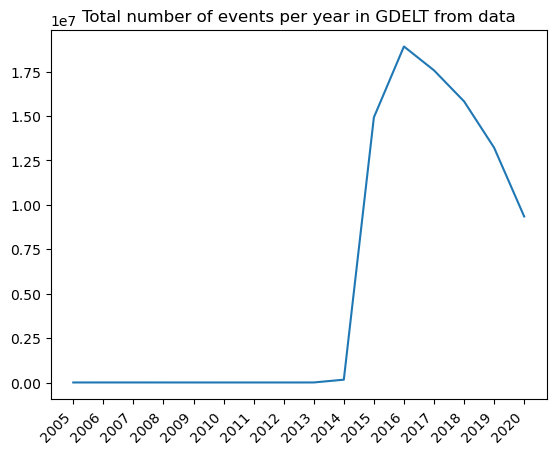

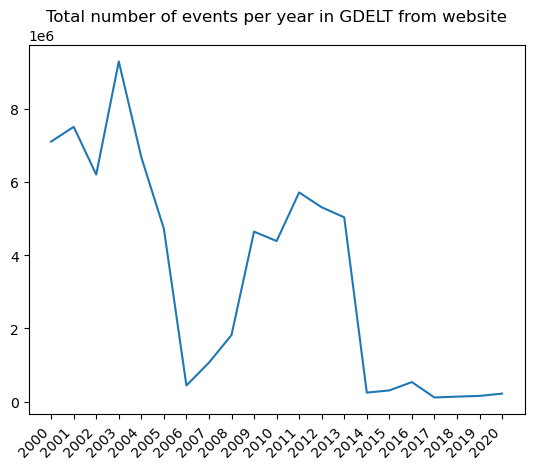

In [25]:
for df, name in zip([bigquery_gdelt, gdelt], ['GDELT from data', 'GDELT from website']):
    df['year'] = df['formatteddate'].str.slice(0, 4)
    df = df[['year', 'Num_Events']]
    df = df.groupby(['year'])
    df = df.sum().reset_index()
    plt.plot(df['year'], df['Num_Events'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Total number of events per year in {name}')
    plt.show()

/tmp/ipykernel_48222/4219294941.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['formatteddate'].str.slice(0, 4)


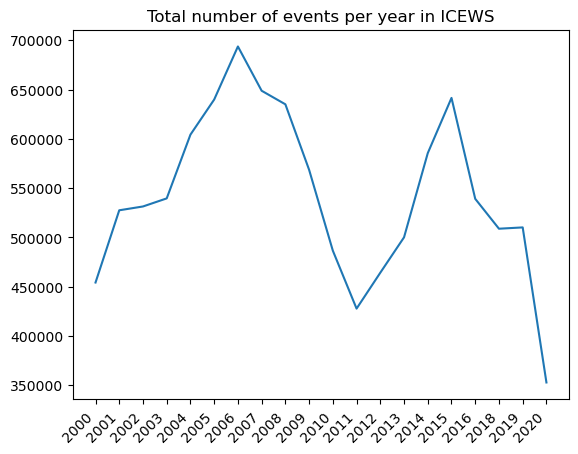

/tmp/ipykernel_48222/4219294941.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['formatteddate'].str.slice(0, 4)


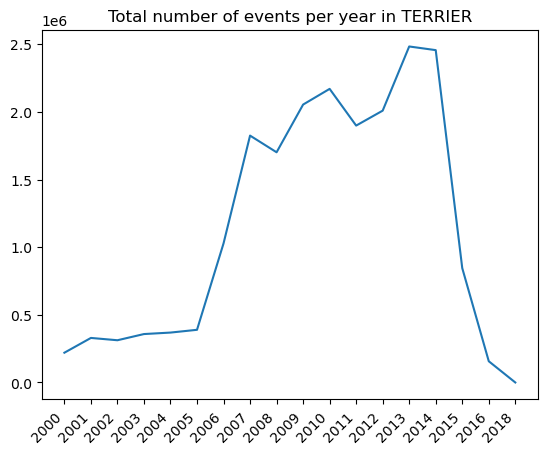

/tmp/ipykernel_48222/4219294941.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['formatteddate'].str.slice(0, 4)


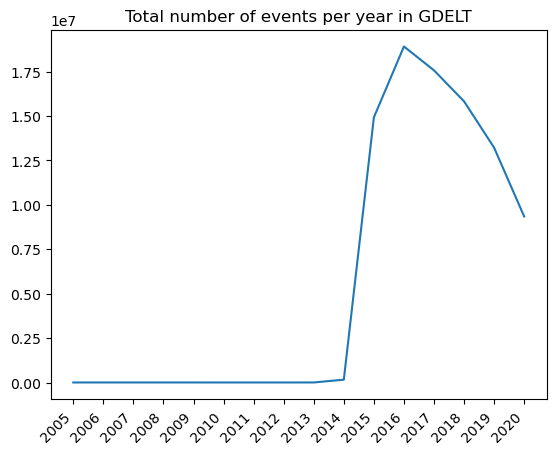

In [26]:
for database in ['ICEWS', 'TERRIER', 'GDELT']:
    df = data[data['Database'] == database]
    df['year'] = df['formatteddate'].str.slice(0, 4)
    df = df[['year', 'Num_Events']]
    df = df.groupby(['year'])
    df = df.sum().reset_index()
    plt.plot(df['year'], df['Num_Events'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Total number of events per year in {database}')
    plt.show()